In [29]:
import numpy as np
import matplotlib.pylab as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow_probability as tfp
tfd = tfp.distributions
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.models import load_model, Sequential, Model

np.random.seed(12211)  

In [30]:
num_train = 200000
num_test = 20000

In [31]:
Trainset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][6]#6
Testset = ['FSPSlin', 'FSPSlog', 'FSPSall', 'OBS', 'UM', 'BP', 'UMnew'][3]

In [32]:
n_epochs = 2000 #20
D = 5 
K = 3

learning_rate = 1e-5
decay_rate= 1e-3 
batch_size = 1024 

save_mod = 'saved_hubs/tf2models/'+'Train_'+Trainset+'_lr_'+str(learning_rate)+'_dr'+str(decay_rate)+'_ne'+str(n_epochs)+'_k'+str(K)+'_nt'+str(num_train)

In [33]:
def minmax_cutsOBSarr(X, y, l):
    # print(X.shape)
    
    mask_cond =  np.where( 
        (X[:, 0] < max_col[0]) & (X[:, 0] > min_col[0]) &
        (X[:, 1] < max_col[1]) & (X[:, 1] > min_col[1]) &
        (X[:, 2] < max_col[2]) & (X[:, 2] > min_col[2]) &
        (X[:, 3] < max_col[3]) & (X[:, 3] > min_col[3]) & 
        (X[:, 4] < max_mag) & (X[:, 4] > min_mag) &
        (y < max_z) & (y > min_z) )
    
    # print( np.array(mask_cond).shape)

    X_new = X[mask_cond]
    y_new = y[mask_cond]
    l_new = l[mask_cond]
    # print(X_new.shape)
    return X_new, y_new, l_new, mask_cond


In [34]:
def print_limits(X, y):
    print(10*'-')
    print('number of datapoints: ', str(y.shape[0]))
    print('z-minmax: ', y.min(), y.max())
    print('ColMag-min: ', np.min(X, axis=0))
    print('ColMag-max: ', np.max(X, axis=0))
    print(10*'-')

In [35]:
def shuffle(X, y):
    shuffleOrder = np.arange(X.shape[0])
    np.random.shuffle(shuffleOrder)
    X = X[shuffleOrder]
    y = y[shuffleOrder]
    return X, y, shuffleOrder

In [36]:
def resample(X, y, n_bins = 200):

    select_per_bin = 50 #np.int(num_train/n_bins) #100

    bins = np.linspace(y.min(), y.max(), n_bins)
    inds = np.digitize(y, bins)

    resampled_ind = []

    for ind_i in range(n_bins):
        ind_bin = np.where(inds==ind_i)
        random_choices = np.min( [select_per_bin, np.size(ind_bin) ])
        index = np.random.choice(ind_bin[0], random_choices, replace=False)
        resampled_ind = np.append(resampled_ind, index)

    resampled_ind = resampled_ind.astype('int')
    all_ind = np.arange(y.shape[0])

    plt.figure(23)
    plt.hist(y, density=True, bins = n_bins, histtype='step', label='original')
    y_resampled = y[resampled_ind]
    X_resampled = X[resampled_ind]

    plt.hist(y_resampled, density=True, bins = n_bins, histtype='step', label='resampled')
    plt.hist(y_train, density=True, bins = n_bins, histtype='step', label='rest')

    plt.legend()
    plt.show()

    print(y_resampled.shape)
    
    return X_resampled, y_resampled, resampled_ind



In [37]:
def loadTrainTest_july(dirIn = 'Data/fromGalaxev/photozs/datasets/data_july_2020/'):

    train_data = np.load(dirIn + 'july14_200k.npy') 
    test_data = np.load(dirIn + 'july13_10k.npy') 
    


    X_train = train_data['color']#[train_data['redshift_flags'] == 0]
    y_train = train_data['redshift']#[train_data['redshift_flags'] == 0]


    X_test = test_data['color']#[test_data['redshift_flags'] == 0]
    y_test = test_data['redshift']#[test_data['redshift_flags'] == 0]

    print_limits(X_train, y_train)
    print_limits(X_test, y_test)

    return X_train, y_train, X_test, y_test


In [38]:
def loadTrainTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_may_2020/'):
    
    # train_data = np.load(dirIn + 'train_' + Trainset +'.npy') 
    test_data = np.load(dirIn + 'test_' + Testset +'.npy') 
    # X_train = train_data[: , :-1]
    # y_train = train_data[: , -1]

    X_test = test_data[: , :-1]
    y_test = test_data[: , -1]

    # print_limits(X_train, y_train)
    print_limits(X_test, y_test)

    if Testset == 'OBS':
        test_labels = np.load(dirIn + 'test_' + Testset + '_label.npy') 

    return _, _, X_test, y_test, test_labels


In [39]:
X_train, y_train, _, _ = loadTrainTest_july(dirIn = 'Data/fromGalaxev/photozs/datasets/data_july_2020/')
_, _, X_test, y_test, label_test = loadTrainTest(dirIn = 'Data/fromGalaxev/photozs/datasets/data_may_2020/')

----------
number of datapoints:  187462
z-minmax:  0.0020016062 1.249997
ColMag-min:  [-0.09145837 -0.05327791 -0.02479261 -0.10519464 12.000012  ]
ColMag-max:  [ 3.825315   2.8303378  1.6937237  1.5019817 23.499979 ]
----------
----------
number of datapoints:  10322
z-minmax:  0.0020014732 1.249283
ColMag-min:  [-4.1676056e-02 -7.1866615e-03  5.6203555e-02 -6.4645730e-02
  1.2003667e+01]
ColMag-max:  [ 3.6190994  2.7985296  1.6097487  1.4396983 23.4981   ]
----------
----------
number of datapoints:  3765
z-minmax:  2.7894168397324393e-06 7.005712509155273
ColMag-min:  [-4.43361855 -3.23018837 -0.86554527 -8.47300148 11.58427238]
ColMag-max:  [ 9.81304723  5.44493866  3.72197151  1.81797218 22.8750425 ]
----------


In [40]:
X_train, y_train, X_trainShuffleOrder = shuffle(X_train, y_train)
# X_test, y_test, label_test, X_testShuffleOrder = shuffleOBS(X_test, y_test, test_labels)

In [41]:
min_col = [-0.09145837, -0.05327791, -0.02479261, -0.10519464] #-0.03 #-5
max_col = [ 3.825315,   2.8303378,  1.6937237,  1.5019817] #3.4 #5
min_mag = 12
max_mag = 23
min_z = 0.0 #np.min(y_train) 
max_z = 1.1 #np.max(y_train) 


X_test, y_test, label_test, mask_cond = minmax_cutsOBSarr(X_test, y_test, label_test)

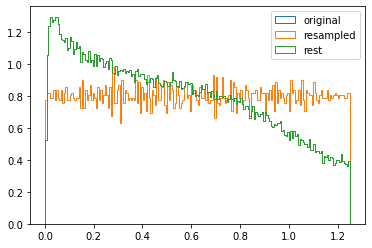

(9950,)


In [42]:
resampleTrain = True

if resampleTrain:
    X_train, y_train, resampled_ind = resample(X_train, y_train)
    # X_test, y_test, resampled_ind_test = resample(X_test, y_test, n_bins=10) ## not really necessary

In [43]:
print("Size of features in training data: {}".format(X_train.shape))
print("Size of output in training data: {}".format(y_train.shape))
print("Size of features in test data: {}".format(X_test.shape))
print("Size of output in test data: {}".format(y_test.shape))

Size of features in training data: (9950, 5)
Size of output in training data: (9950,)
Size of features in test data: (2926, 5)
Size of output in test data: (2926,)


In [44]:

preproc = Pipeline([('stdscaler', StandardScaler())])
X_train = preproc.fit_transform(X_train)
X_test = preproc.transform(X_test)
preproc_y = Pipeline([('stdscaler', MinMaxScaler())])

y_train = preproc_y.fit_transform(y_train.reshape(-1, 1))
y_test = preproc_y.transform(y_test.reshape(-1, 1))

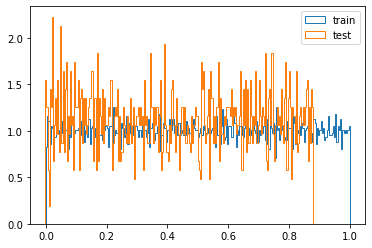

In [45]:
plt.figure(23)

plt.hist(y_train, density=True, bins = 250, histtype='step', label='train')
plt.hist(y_test, density=True, bins = 250, histtype='step', label='test')
plt.legend()

In [46]:
non_lin_act = tf.nn.relu #tf.nn.tanh
y_true = tf.keras.Input(shape=(1,))
inputs = tf.keras.Input(shape=(D,))
layer_1 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(inputs)
layer_1a = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1)
layer_1b = tf.keras.layers.Dense(units=2048, activation=non_lin_act)(layer_1a)
layer_1c = tf.keras.layers.Dense(units=1024, activation=non_lin_act)(layer_1b)
layer_2 = tf.keras.layers.Dense(units=512, activation=non_lin_act)(layer_1c)
layer_3 = tf.keras.layers.Dense(units=256, activation=non_lin_act)(layer_2)
layer_4 = tf.keras.layers.Dense(units=128, activation=non_lin_act)(layer_3)
layer_5 = tf.keras.layers.Dense(units=64, activation=non_lin_act)(layer_4)
layer_6 = tf.keras.layers.Dense(units=32, activation=non_lin_act)(layer_5)
mu = tf.keras.layers.Dense(units=K, activation=None, name="mu")(layer_6)
var = tf.keras.backend.exp(tf.keras.layers.Dense(units=K, activation=tf.nn.softplus, name="sigma")(layer_6))
pi = tf.keras.layers.Dense(units=K, activation=tf.nn.softmax, name="mixing")(layer_6)

model_train = Model([inputs, y_true], [mu, var, pi], name='mdn')

In [47]:
# Define custom loss
def custom_loss(layer):
    # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
    def loss(y_true, mu, var, pi):
        mixture_distribution = tfp.distributions.Categorical(probs=pi)
        distribution = tfp.distributions.Normal(loc=mu, scale=var)
        likelihood = tfp.distributions.MixtureSameFamily(mixture_distribution=mixture_distribution,components_distribution=distribution)

        log_likelihood = -1.0*likelihood.log_prob(tf.transpose(y_true))
        mean_loss = tf.reduce_mean(log_likelihood)

        return mean_loss
    return loss
    
# Compile the model
model_train.add_loss(custom_loss(inputs)(y_true, mu, var, pi))


model_train.compile(optimizer='adam')
model_train.summary()

Model: "mdn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 512)          3072        input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 1024)         525312      dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 2048)         2099200     dense_10[0][0]                   
________________________________________________________________________________________________

In [48]:
model_train.load_weights(save_mod + '.h5')

y_pred = np.array(model_train(X_test))

In [49]:
y_pred_arg = np.argmax(y_pred[2, :, :], axis = 1)
y_pred_mean = y_pred[0, :, :][:, y_pred_arg][:, 0]
y_pred_std = np.sqrt(np.log(y_pred[1, :, :][:, y_pred_arg][:, 0]))

In [50]:
y_pred_3means = preproc_y.inverse_transform(y_pred[0, :, :])
y_pred_3std = preproc_y.inverse_transform( np.sqrt(np.log(y_pred[1, :, :])  ))
y_pred_3weights = y_pred[2, :, :]

y_test_all = preproc_y.inverse_transform(y_test)


predstdweights = np.array([y_pred_3means, y_pred_3std, y_pred_3weights])
truelabel = np.array([y_test_all[:, 0], label_test])

# np.save(save_mod+'test_true', predstdweights )
# np.save(save_mod+'test_pred', truelabel )

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


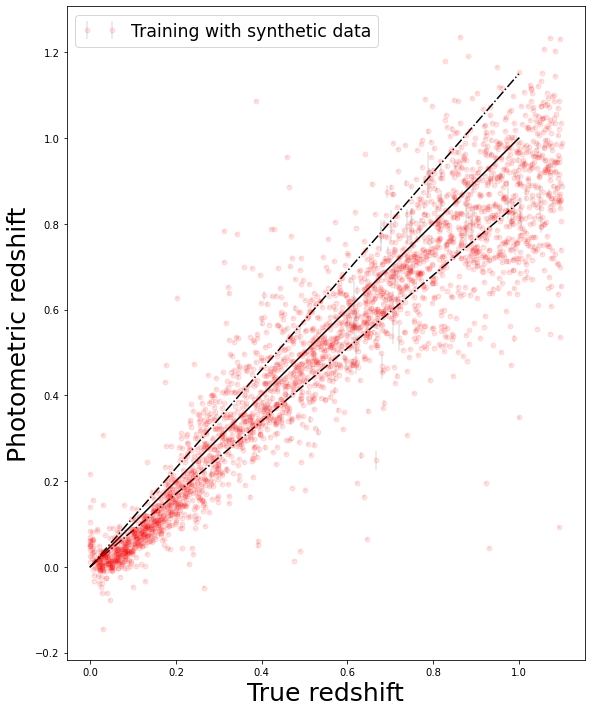

In [51]:
# fig = plt.figure(22)



ifPlotWeighted = True
y_pred_mean_best = y_pred_mean
y_pred_std_best = y_pred_std


if ifPlotWeighted:
    plt.figure(22, figsize=(10, 10))


    plt.errorbar(preproc_y.inverse_transform(y_test)[:, 0], preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1) )[:, 0], fmt='ro', ecolor='k', ms = 5, alpha = 0.1, label = 'Training with synthetic data')
    



plt.plot([0, 1], [0, 1], 'k')
plt.plot([0, 1], 0.85*np.array([0, 1]), 'k-.')
plt.plot([0, 1], 1.15*np.array([0, 1]), 'k-.')


plt.ylabel(r'Photometric redshift', fontsize=25)
plt.xlabel(r'True redshift', fontsize=25)

plt.tight_layout()

plt.axes().set_aspect('equal')


leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

for artist, text in zip(leg.legendHandles, leg.get_texts()):
    col = artist.get_color()
    if isinstance(col, np.ndarray):
        col = col[0]
    text.set_color(col)
    text.set_alpha(1.0)


plt.savefig('phoz_compare.pdf', bbox_inches='tight')

plt.show()

/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/nramachandra/anaconda3/envs/env_py37/lib/python3.7/site-packages/ipykernel_launcher.py:45: MatplotlibDeprecationWarning: Adding an axes using

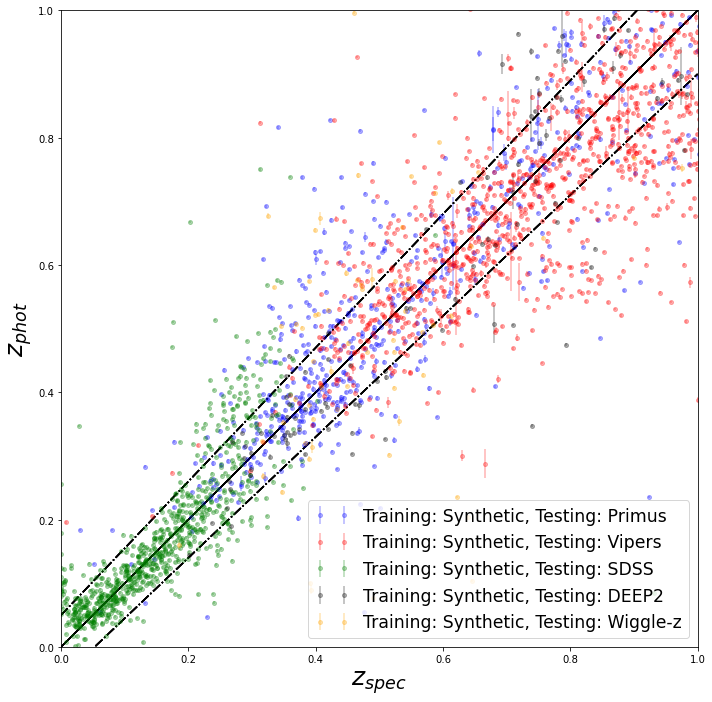

In [52]:


ifPlotWeighted = True

if ifPlotWeighted:
    

    colorstring = ['b', 'r', 'g', 'k', 'orange']
    surveystring = ['Primus', 'Vipers', 'SDSS', 'DEEP2', 'Wiggle-z']


    for label_ind in [0, 1, 2, 3, 4]:

        plt.figure(22, figsize=(10, 10,))

        surveyindx = np.where(label_test == label_ind)

        offset = 0.04
        
        plt.errorbar(preproc_y.inverse_transform(y_test)[surveyindx][:, 0], offset + preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx][:, 0], yerr= preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx][:, 0], fmt = 'o', marker=None, ms = 4, alpha = 0.3, label = 'Training: Synthetic, Testing: '+surveystring[label_ind], c = colorstring[label_ind])


        C = 0.05
        z_t = np.array([0, 1])
        z_tp = z_t + C*(1+z_t)
        z_tm = z_t - C*(1+z_t)

        plt.plot(z_t, z_t, 'k')



        plt.plot(z_t, z_tp, 'k-.')
        plt.plot(z_t, z_tm, 'k-.')




        plt.ylabel(r'$z_{phot}$', fontsize=25)
        plt.xlabel(r'$z_{spec}$', fontsize=25)
        
        plt.xlim(0.0, 1)
        plt.ylim(0.0, 1)


        plt.tight_layout()

        plt.axes().set_aspect('equal')


        leg = plt.legend(fontsize = 'xx-large', markerscale=1., numpoints=2)

        trueprederr = np.array([preproc_y.inverse_transform(y_test)[surveyindx], offset + (preproc_y.inverse_transform(y_pred_mean_best.reshape(-1, 1))[surveyindx]), preproc_y.inverse_transform(y_pred_std_best.reshape(-1, 1))[surveyindx]])
        np.save(save_mod + 'test_label_' +str(label_ind), trueprederr)



plt.savefig('phoz_compare_surveys.pdf', bbox_inches='tight')

plt.show()
